![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Análise Exploratória com Inferência de Efeito Causal a partir de SRAGs

Neste *notebook* analisamos os dados reportados de casos de Síntrome Respiratória Aguda Grave (SRAG), sob a hipótese de que desse número se possa estimar uma boa aproximação do número real da incidência de COVID-19, já que supõe-se que a epidemia esteja subnotificada. A inferência de efeito causal é feita de modo rudimentar, empregando-se a versão Python da biblioteca [CausalImpact](https://github.com/dafiti/causalimpact).

Os dados analisados foram extraídos do sistema [Info Gripe da Fiocruz](http://info.gripe.fiocruz.br/) por um [*scrapper* não-oficial](https://github.com/belisards/srag_brasil/) (até o momento, não encontramos modo mais conveniente de acessar os dados originais diretamente).

**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [17]:
import os
import math
from causalimpact import CausalImpact
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [64]:
plt.style.use('fivethirtyeight')

Se necessário, ajuste o diretório de trabalho para ser o que contém este *notebook*.

In [65]:
#print(os.getcwd())
#os.chdir('covid19-analytics/notebooks')
#os.getcwd()

Tomemos o cuidado de determinar o dia em que as semanas epidemiológicas terminam, que [parece ser aos sábados](https://portalsinan.saude.gov.br/calendario-epidemiologico).

In [145]:
week_offset = pd.offsets.Week(weekday=5)

## Leitura e Preparação



In [144]:
df_covid = pd.read_csv(f'../data/ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])

df_covid_target = df_covid[df_covid['location'] == 'Brazil'].set_index('date').resample(week_offset).sum()
df_covid_target.head(15)

,new_cases,new_deaths,total_cases,total_deaths
date,,,,
2020-01-04,0,0,0,0
2020-01-11,0,0,0,0
2020-01-18,0,0,0,0
2020-01-25,0,0,0,0
2020-02-01,0,0,0,0
2020-02-08,0,0,0,0
2020-02-15,0,0,0,0
2020-02-22,0,0,0,0
2020-02-29,1,0,4,0


In [67]:
# https://github.com/belisards/srag_brasil/
df_srag_raw = pd.read_csv(f'../data/srag_brasil/casos_br.csv')

df_srag_raw.head()

,ano,epiweek,casos,territory_name,situation_name,value
0,2009,1,0,Brasil,Dado estável. Sujeito a pequenas alterações.,0
1,2010,1,163,Brasil,Dado estável. Sujeito a pequenas alterações.,163 (100.0 % do país)
2,2011,1,31,Brasil,Dado estável. Sujeito a pequenas alterações.,31 (100.0 % do país)
3,2012,1,70,Brasil,Dado estável. Sujeito a pequenas alterações.,70 (100.0 % do país)
4,2013,1,84,Brasil,Dado estável. Sujeito a pequenas alterações.,84 (100.0 % do país)


## Comparação Das Semanas Epidemiológicas

Como foi a incidência de SRAG ao longo dos anos, quando comparamos as mesmas semanas?

In [150]:
cols = {}
timeline = []
years = df_srag_raw['ano'].unique()
for year in years:
    cols[year] = df_srag_raw[df_srag_raw['ano'] == year].sort_values('epiweek')['casos'].reset_index(drop=True)
    timeline = timeline + list(cols[year].values)

df_srag_timeline = pd.DataFrame(timeline) 
df_srag = pd.DataFrame(cols)
df_srag.head()

,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0,163,31,70,84,88,124,104,205,207,288,300.0
1,0,131,23,48,80,143,127,97,177,185,267,336.0
2,0,110,26,51,79,135,110,111,164,181,233,316.0
3,0,122,19,55,100,117,96,116,172,156,246,314.0
4,0,123,31,48,94,126,111,132,220,160,288,312.0


Text(0.5, 1.0, 'SRAG por semana epidemiológica por ano')

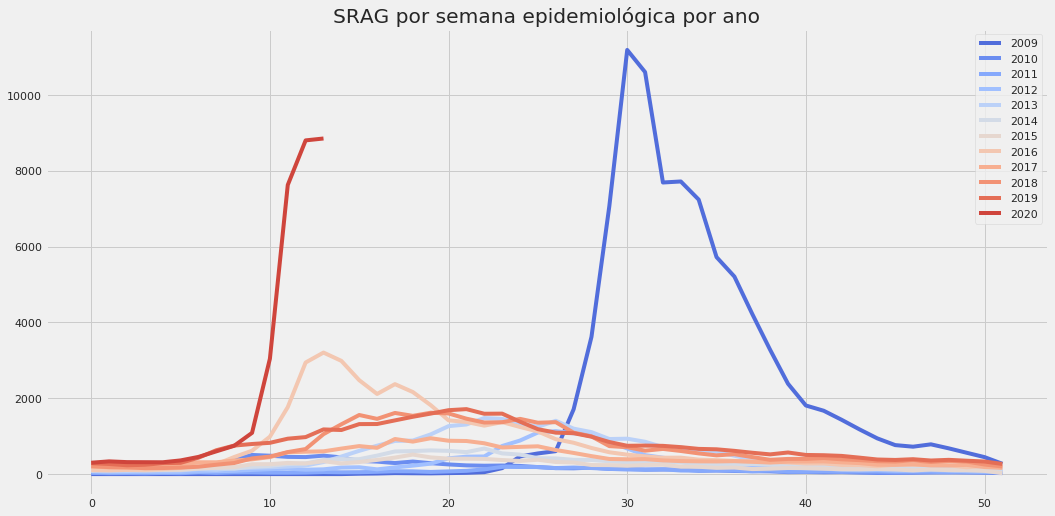

In [159]:
palette = sns.color_palette("coolwarm", len(df_srag.columns))
ax = sns.lineplot(data=df_srag, palette=palette, dashes=False)
ax.set_title('SRAG por semana epidemiológica por ano')

Uma visão alternativa para esses mesmos dados, que enfatiza a proporção em cada ano.

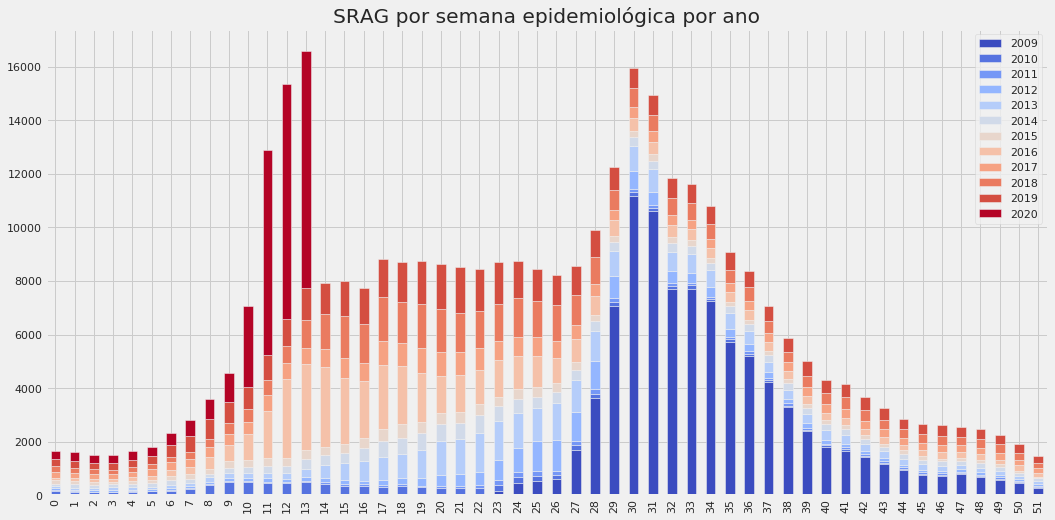

In [158]:
df_srag.plot(kind='bar', stacked=True, colormap='coolwarm', title='SRAG por semana epidemiológica por ano')

Vemos que em 2009 houve um pico bastante anormal, certamente por conta da epidemia de H1N1.

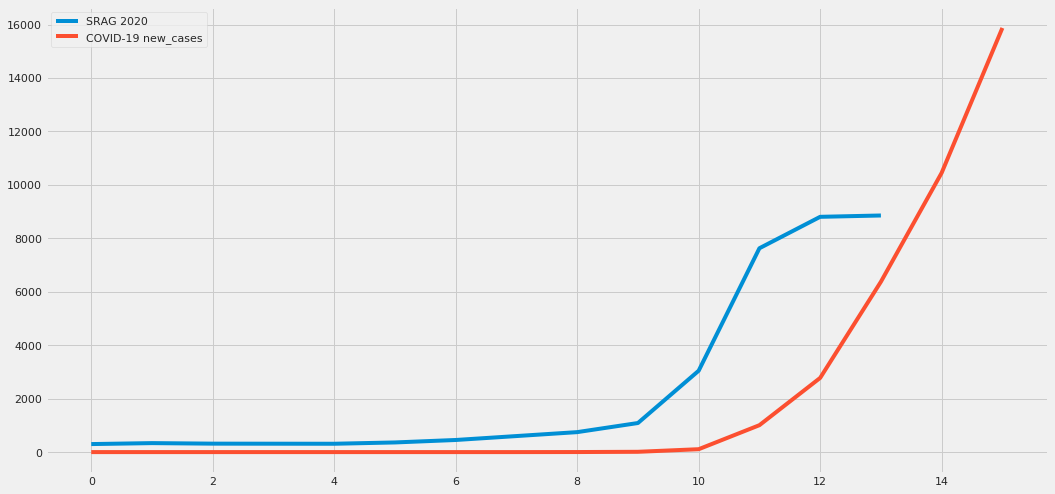

In [85]:
df_comparison =pd.concat([df_srag[2020].rename('SRAG 2020'), 
                          df_covid_target['new_cases'].rename('COVID-19 new_cases').reset_index(drop=True)], axis=1)

ax = sns.lineplot(data=df_comparison, dashes=False)

Qual a magnitude da diferença ao longo do tempo?

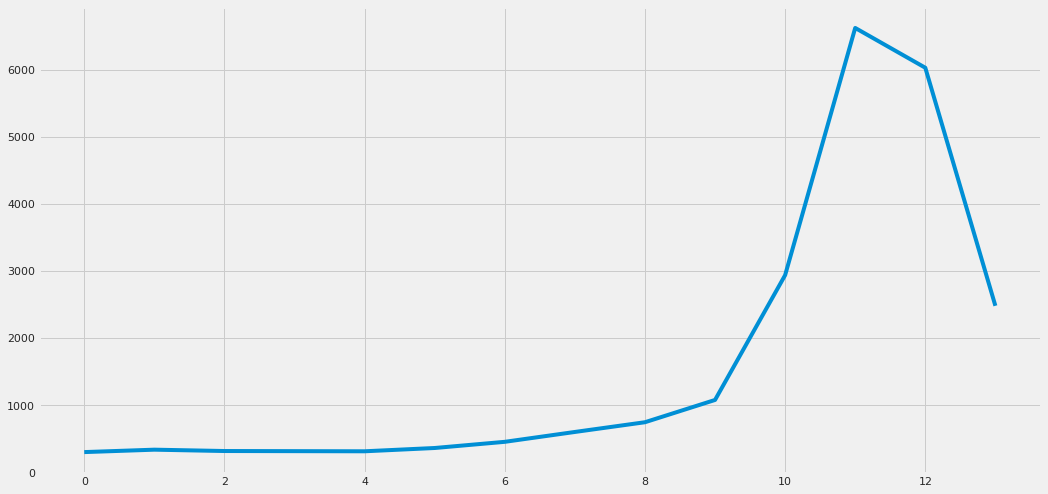

In [71]:
ax = sns.lineplot(data=(df_comparison.iloc[:, 0] - df_comparison.iloc[:, 1]), dashes=False)

## Estimativa de Efeito Causal: CausalImpact

Para estimar o efeito causal supostamente introduzido pela COVID-19, usaremos [a biblioteca CausalImpact](https://github.com/dafiti/causalimpact), a qual exige que os dados sejam dispostos de forma linear no tempo.

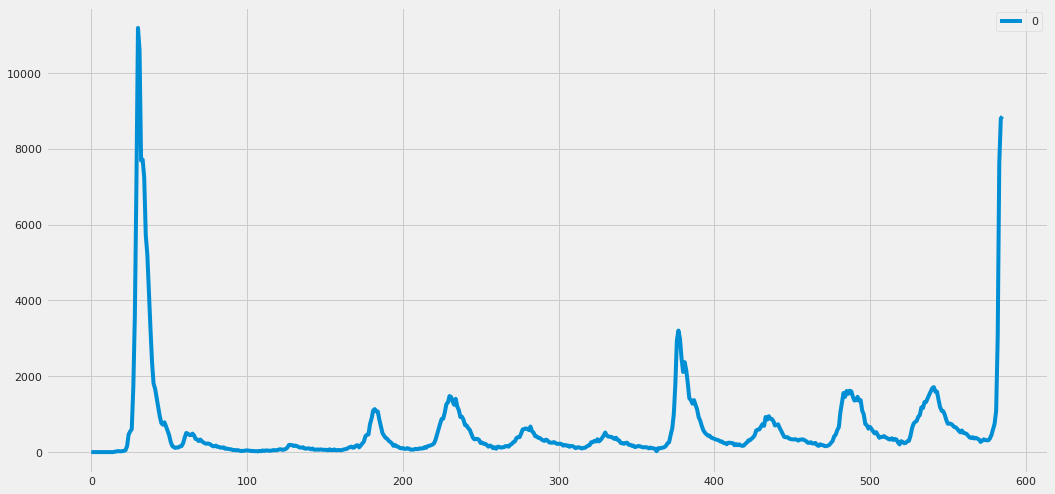

In [72]:
ax = sns.lineplot(data=df_srag_timeline, dashes=False)

Coloquemos a suposta intervenção causal na primeira semana de 2020.

In [87]:
years

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020])

Intervention week: 572
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    2527.54            32858.0
Prediction (s.d.)         658.38 (312.26)    8558.92 (4059.43)
95% CI                    [34.03, 1258.08]   [442.39, 16355.07]

Absolute effect (s.d.)    1869.16 (312.26)   24299.08 (4059.43)
95% CI                    [1269.46, 2493.51] [16502.93, 32415.61]

Relative effect (s.d.)    283.9% (47.43%)    283.9% (47.43%)
95% CI                    [192.82%, 378.73%] [192.82%, 378.73%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


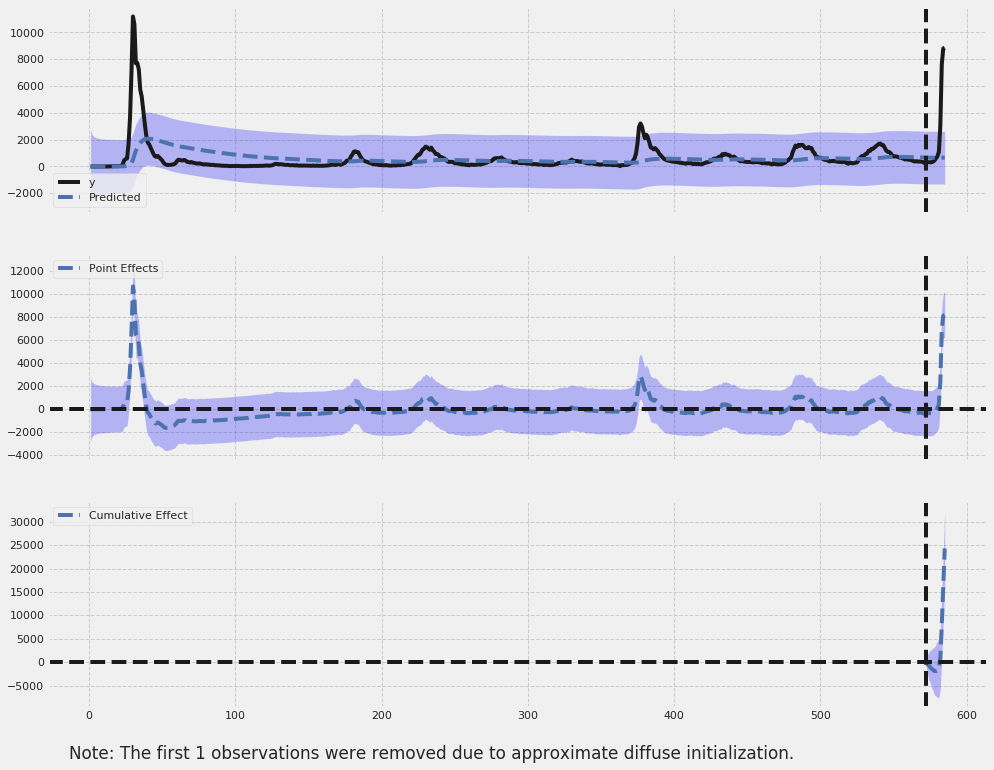

In [191]:
intervention_week = (len(years) - 1) * 52  # all years, except the last one
print("Intervention week:", intervention_week)
pre_period = [0, intervention_week]
post_period = [intervention_week+1, 585]

ci = CausalImpact(df_srag_timeline, pre_period, post_period)
print(ci.summary())
#print(ci.summary(output='report'))
ci.plot()

Podemos então isolar o efeito estimado.

In [195]:
df_causal_effect_1 = ci.inferences.dropna()[['point_effects', 'point_effects_lower', 'point_effects_upper']]
df_causal_effect_1#.head()

,point_effects,point_effects_lower,point_effects_upper
573,-322.378514,-2292.619253,1647.862226
574,-342.378514,-2312.770936,1628.013908
575,-344.378514,-2314.922607,1626.165579
576,-346.378514,-2317.074266,1624.317239
577,-297.378514,-2268.225914,1673.468886
578,-205.378514,-2176.377550,1765.620522
579,-58.378514,-2029.529174,1912.772146
580,88.621486,-1882.680787,2059.923759
581,429.621486,-1541.832388,2401.075360
582,2386.621486,415.016023,4358.226950


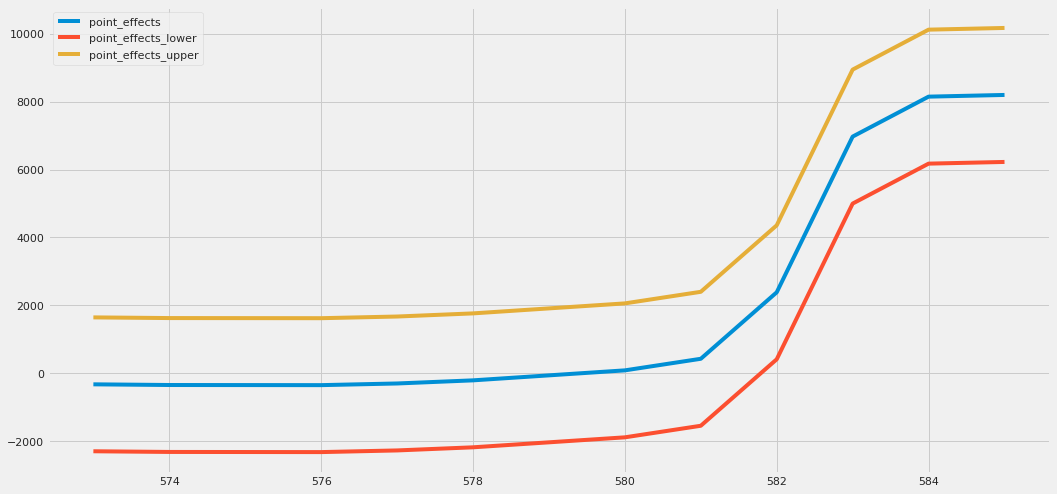

In [196]:
ax = sns.lineplot(data=df_causal_effect_1, dashes=False)

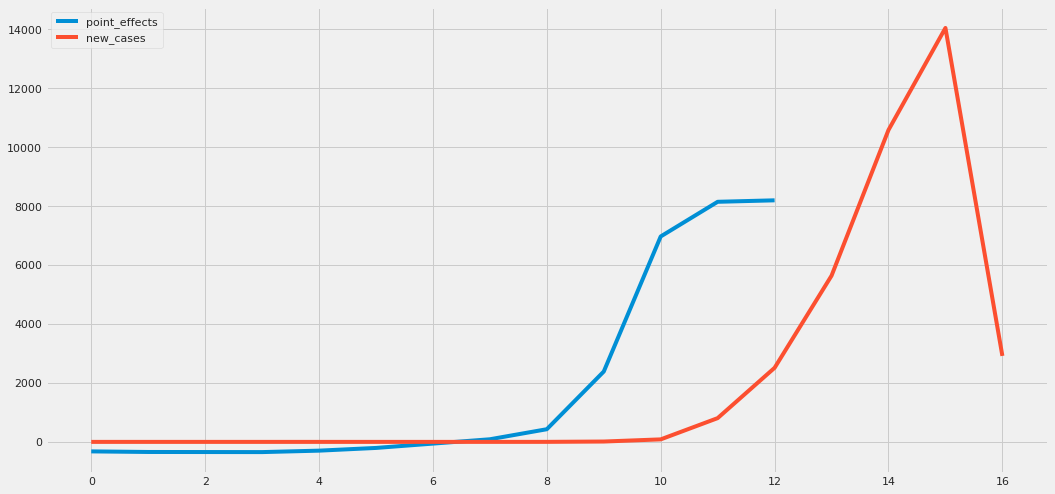

In [198]:
df_comparison_2 =pd.concat([df_causal_effect_1['point_effects'].reset_index(drop=True), 
                            df_covid_target['new_cases'].reset_index(drop=True)], axis=1)

ax = sns.lineplot(data=df_comparison_2, dashes=False)

E calcular a razão entre SRAGs e COVID-19 oficial.

8     429.621486
9     198.885124
10     81.995547
11     10.106230
12      3.261290
dtype: float64

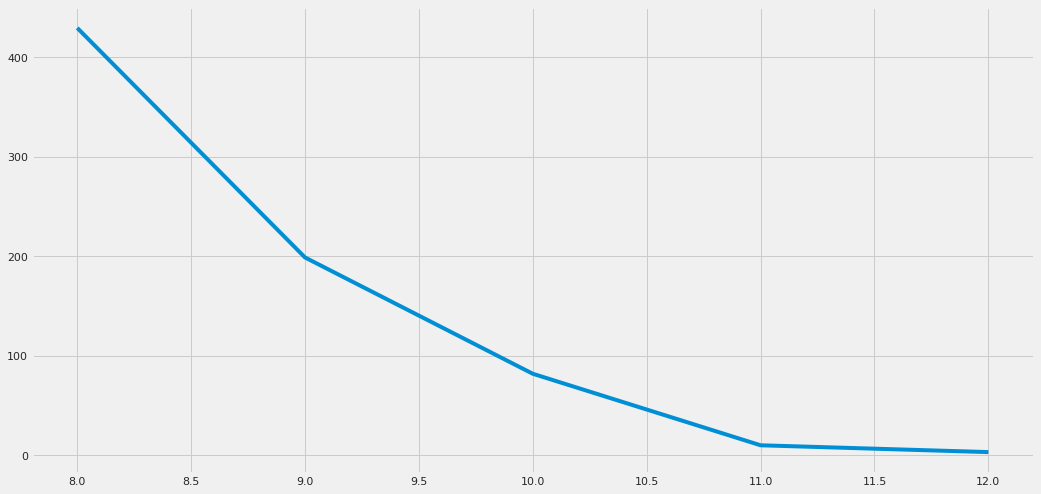

In [224]:
s_a = df_causal_effect_1['point_effects'].reset_index(drop=True)
s_b =  df_covid_target['new_cases'].reset_index(drop=True)
s_ratio_1 = (s_a/s_b)
s_ratio_1 = s_ratio_1[(s_ratio_1 != np.inf) & (s_ratio_1 != -np.inf)].dropna()
ax = sns.lineplot(data=s_ratio_1, 
                  dashes=False)
s_ratio_1

## Estimativa de Efeito Causal: Manual

Façamos agora uma análise manual, supondo-se que as mesmas semanas epidemiológicas em anos diferentes tendem a ter comportamentos semelhantes, salvo em casos excepcionais. Assim, iremos atribuir a diferença (média, mínima, máxima) observada nas semanas do ano corrente a algum fator novo, nomeadamente à COVID-19.

In [185]:
s_srag_cur = df_srag.iloc[:, -1]
df_srag_past = df_srag.iloc[:, :-1]

In [186]:
s_effect_lower = (s_srag_cur - df_srag_past.max(axis=1)).rename('causal_effect_lower')
s_effect_upper = (s_srag_cur - df_srag_past.min(axis=1)).rename('causal_effect_upper')
s_effect_mean = (s_srag_cur - df_srag_past.mean(axis=1)).rename('causal_effect_mean')


df_causal_effect_2 = pd.concat([s_effect_mean, s_effect_lower, s_effect_upper], axis=1) 
df_causal_effect_2.head(15)

,causal_effect_mean,causal_effect_lower,causal_effect_upper
0,176.000000,12.0,300.0
1,219.818182,69.0,336.0
2,206.909091,83.0,316.0
3,205.000000,68.0,314.0
4,190.818182,24.0,312.0
5,228.636364,64.0,361.0
6,282.727273,21.0,453.0
7,397.454545,-29.0,600.0
8,488.363636,-5.0,747.0
9,770.727273,294.0,1088.0


8     488.363636
9      64.227273
10     31.512299
11      8.872434
12      3.265926
13      1.445437
dtype: float64

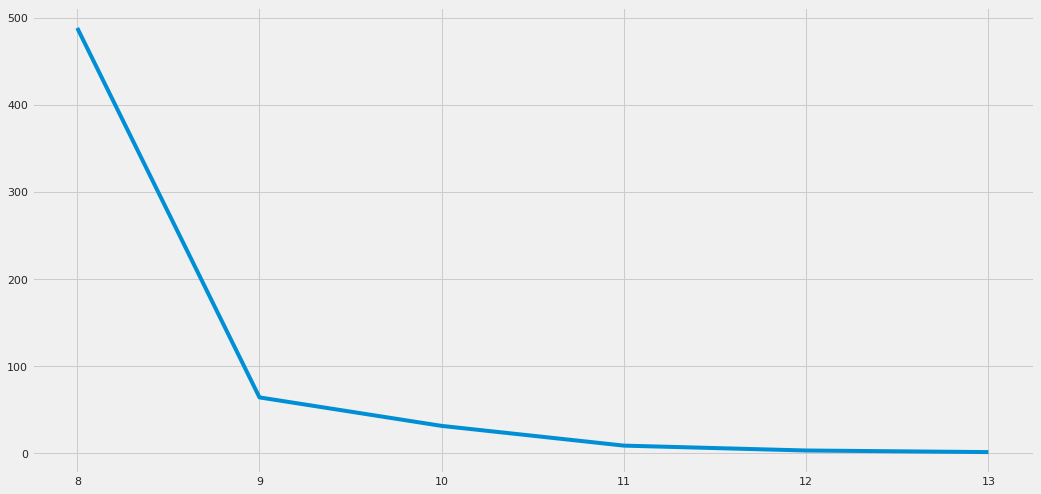

In [231]:
s_a = df_causal_effect_2['causal_effect_mean'].reset_index(drop=True)
s_b =  df_covid_target['new_cases'].reset_index(drop=True)

s_ratio_2 = (s_a/s_b)

s_ratio_2 = s_ratio_2[(s_ratio_2 != np.inf) & (s_ratio_2 != -np.inf)].dropna()
ax = sns.lineplot(data=s_ratio_2, 
                  dashes=False)
s_ratio_2

Os resultados dessa última estimativa de efeito causal parecem mais confiáveis, então a tomaremos como base para a conclusão deste estudo.

In [232]:
s_ratio = s_ratio_2

## Conclusão

Nota-se grande discrepância entre casos usuais de SRAG e casos reportados. Atribuimos assim os casos adicionais à COVID-19. Note-se ainda que os casos de SRAG reportados referem-se a hospitalizações, que são apenas uma parte dos casos totais esperados de COVID-19. Portanto, para se estimar os casos totais de COVID-19, devemos ainda ajustar a estimativa de hospitalizados de acordo com a probabilidade de ser hospitalizado dado que se tem COVID-19.

In [233]:
p_hospitalization = 0.2

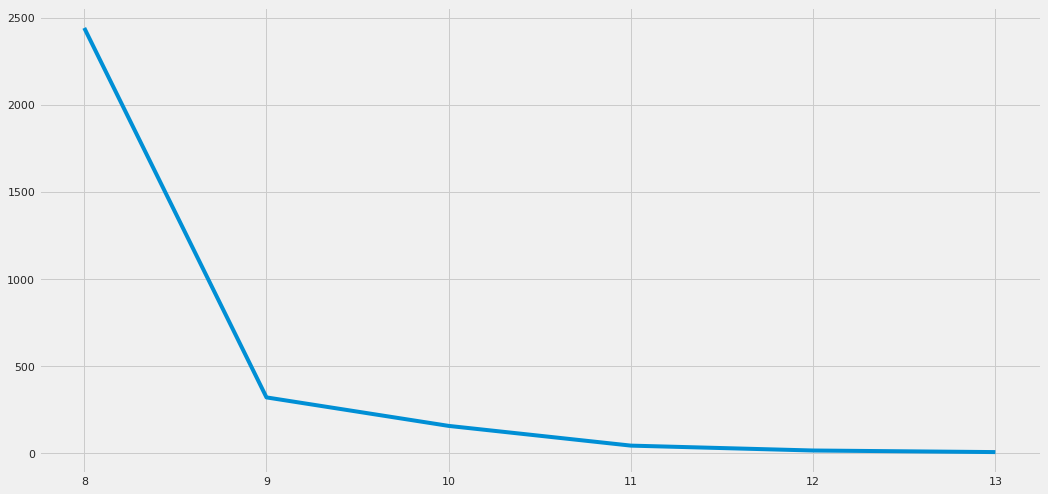

In [234]:
s_adjustment_multipler = s_ratio[s_ratio > 0] / p_hospitalization
s_adjustment_multipler = s_adjustment_multipler.rename('SRAG_adjustment_multiplier')
ax = sns.lineplot(data=s_adjustment_multipler, 
                  dashes=False)

Vemos assim que as diferenças estimadas são bastante expressivas, o que deve ter impacto na previsão da dinâmica epidemiológica.

Salvemos esses multiplicadores de ajuste para uso posterior. Por conveniência, vamos diarizar esses valores.

In [235]:
weeks = range(0, s_adjustment_multipler.index[-1])

In [236]:
df_daily_adjustment_multipler = \
    df_covid_target\
        .reset_index()\
        .merge(s_adjustment_multipler, left_index=True, right_index=True)\
        .set_index('date')\
        .resample('D')\
        .bfill()\
        [['SRAG_adjustment_multiplier']]

df_daily_adjustment_multipler

,SRAG_adjustment_multiplier
date,
2020-02-29,2441.818182
2020-03-01,321.136364
2020-03-02,321.136364
2020-03-03,321.136364
2020-03-04,321.136364
2020-03-05,321.136364
2020-03-06,321.136364
2020-03-07,321.136364
2020-03-08,157.561497


In [217]:
df_daily_adjustment_multipler.to_csv('../results/srag_adjustment_multipliers.brazil.csv')